## NFL Edge Prediction Problem

# Objectives: 

- **Create a complete graph of NFL games. **Each season the NFL can be thought of as a network between every team in the NFL (nodes) with games connecting the teams (edges). There can be many different "weights" or variables attached to each edge, with whether the team won, being the most import. The NFL can also be thought of a direct network with edge direction being point at the home team. <br>
- **Set up and test triad logic.**  Adapting social media analysis to the NFL. This idea was first introduced by Professor Leskovec. It equates to if a team beats their opponent, and then that opponent plays another game and beats a different team, then the original team should beat that third team.   <br>
- **Run a logistic regression models to compare to.**<br>
- **Bring in additional team meta data (offensive).** In the modern NFL, offense has become king. Bringing in the total season offensive statistics should provide some light into how important having a good offense is in the NFL. <br>
- **Add in additional logic into the triad/triangle prediction.** <br>

## Presenting the initial data: 

<b>Data Fields: </b>
<b>GameID</b> - A unique identifier for each game of 2009 - 2017 NFL Seasons. <br>
<b>Date</b> - Date that the game took place on. <br>
<b>home</b> - Abrevation of the home team. <br>
<b>away</b> - Abrevation of the away team. <br>
<b>homescore</b> - Amount of points that the home team scored during the game. <br>
<b>awayscore</b> - Amount of points that the away team scored during the game. <br>
<b>Season</b> - Season that the game took place, data has games from the 2009-2017 seasons.<br>
<b>homeawaydiff</b> - Difference between the home score and away score. Also called home margin.<br>
<b>homekey</b> - Combination of the home team abrevation and season. Used to join additional data sets.<br>
<b>awaykey</b> - Combination of the away team abrevation and season. Used to join additional data sets.<br>
<b>homewin</b> - Dependent variable that I am trying to predict. Can either be Y/N. Will be N in case of a tie.<br>
<b>Combinescore</b> - Total score/points of both teams. <br>
<b>predhomewin</b> - Copy of homewin column used to compare the predicition. <br>
<b>testededge</b> - Indicator if the edge was tested. <br>
<b>year</b> - Year that the game took place on. <br>
<b>month</b> - Month that the game took place on. <br>
<b>week</b> - Week that the game took place on. <br>
<b>nflweek</b> - Date that the game took place on. <br>
<b>day</b> - Week day that the game took place on. 3=Thursday, 6=Sunday, 0=Monday <br>
<b>joindate</b> - Date that the game took place on. <br>


2009-2017 game result data was pulled from NFLScrapr GitHub (https://github.com/ryurko/nflscrapR-data/tree/master/legacy_data/season_games). Offensive ranking data was scraped from Pro Football Reference (https://www.pro-football-reference.com/years/2016/) using R and the rvest package within R. Code is attached in the appendix. 

**Importing necessary libraries**

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import networkx as nx
import matplotlib.pyplot as plt
import sklearn
import random
import seaborn as sns
sns.set()
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score



# to set a style to all graphs
plt.style.use('fivethirtyeight')

Read in games csv file and add additional columns. Data description is listed above

In [3]:
edgelist=pd.read_csv('nflgamestotal.csv')
edgelist['combinedscore']=edgelist['homescore']+edgelist['awayscore']
edgelist['predhomewin']=edgelist['homewin']
edgelist['tested edge']=0
pd.to_datetime(edgelist.date,infer_datetime_format=True)
edgelist['year'] = pd.DatetimeIndex(edgelist['date']).year
edgelist['month'] = pd.DatetimeIndex(edgelist['date']).month
edgelist['week'] = pd.DatetimeIndex(edgelist['date']).week
edgelist['nflweek']=edgelist['week']-36
edgelist['day']=pd.DatetimeIndex(edgelist['date']).weekday
edgelist['joindate']=edgelist['year'].map(str) + edgelist['nflweek'].map(str)
edgelist['homewinbi']=np.where(edgelist['homewin']=='Y', 1, 0)
#edgelist.home.unique()

Bring in abrevation table to join with offensive ranking dataset to match with game result dataset. More than 32 teams due to the franchises switching locations, i.e. St. Louis Rams to LA Rams

In [22]:
abr=pd.read_csv('nflacronyms.csv', delimiter = '\t')
abr.head()
abr.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6'],axis=1)

,Acronym,Franchise
0,ARI,Arizona Cardinals
1,ATL,Atlanta Falcons
2,BAL,Baltimore Ravens
3,BUF,Buffalo Bills
4,CAR,Carolina Panthers
5,CHI,Chicago Bears
6,CIN,Cincinnati Bengals
7,CLE,Cleveland Browns
8,DAL,Dallas Cowboys
9,DEN,Denver Broncos


Bringing in offensive rank data. The rank number was sorted amount of points scored in a total season, i.e. #3 means that team scored the third most points in that season.

In [23]:
offensive=pd.read_csv('nfloffensivetotal.csv')
offensive=pd.merge(offensive, abr, left_on = 'Tm', right_on = 'Franchise')
offensive['offensivekey']=offensive['Acronym'].map(str)+offensive['season'].map(str)
offrank = offensive[['OffRk', 'offensivekey']].copy()
offensive.head()

,OffRk,Tm,G,PF,Yds,Ply,Y/P,TO,FL,1st,...,EXP,season,Acronym,Franchise,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,offensivekey
0,1.0,New Orleans Saints,16.0,510.0,6461.0,1032.0,6.3,28.0,16.0,348.0,...,170.92,2009,NO,New Orleans Saints,NaN,NaN,NaN,NaN,NaN,NO2009
1,11.0,New Orleans Saints,16.0,384.0,5960.0,1067.0,5.6,31.0,9.0,351.0,...,98.07,2010,NO,New Orleans Saints,NaN,NaN,NaN,NaN,NaN,NO2010
2,2.0,New Orleans Saints,16.0,547.0,7474.0,1117.0,6.7,19.0,5.0,416.0,...,330.95,2011,NO,New Orleans Saints,NaN,NaN,NaN,NaN,NaN,NO2011
3,3.0,New Orleans Saints,16.0,461.0,6574.0,1067.0,6.2,24.0,5.0,352.0,...,142.90,2012,NO,New Orleans Saints,NaN,NaN,NaN,NaN,NaN,NO2012
4,10.0,New Orleans Saints,16.0,414.0,6391.0,1079.0,5.9,19.0,7.0,359.0,...,152.24,2013,NO,New Orleans Saints,NaN,NaN,NaN,NaN,NaN,NO2013


Joining edgelist dataframe (game results) with offensive dataframe (offensive ranks) twice to give offensive rankings for both home and away teams. 

In [24]:
edgelist=pd.merge(edgelist, offrank, left_on = 'homekey', right_on = 'offensivekey')
#edgelist.drop(columns=['OffRk_y', 'offensivekey_y'])
edgelist=pd.merge(edgelist, offrank, left_on = 'awaykey', right_on = 'offensivekey')
edgelist.columns = ['awayoffrank' if x=='OffRk_y' else x for x in edgelist.columns]
edgelist.columns = ['awayoffkey' if x=='offensivekey_y' else x for x in edgelist.columns]
edgelist.head()

,GameID,date,home,away,homescore,awayscore,Season,homeawaydiff,homekey,awaykey,...,month,week,nflweek,day,joindate,homewinbi,OffRk_x,offensivekey_x,awayoffrank,awayoffkey
0,2009091000,2009-09-10,PIT,TEN,13,10,2009,3,PIT2009,TEN2009,...,9,37,1,3,20091,1,12.0,PIT2009,16.0,TEN2009
1,2009112300,2009-11-23,HOU,TEN,17,20,2009,-3,HOU2009,TEN2009,...,11,48,12,0,200912,0,10.0,HOU2009,16.0,TEN2009
2,2009120604,2009-12-06,IND,TEN,27,17,2009,10,IND2009,TEN2009,...,12,49,13,6,200913,1,7.0,IND2009,16.0,TEN2009
3,2010010315,2010-01-03,SEA,TEN,13,17,2009,-4,SEA2009,TEN2009,...,1,53,17,6,201017,0,25.0,SEA2009,16.0,TEN2009
4,2009101810,2009-10-18,NE,TEN,59,0,2009,59,NE2009,TEN2009,...,10,42,6,6,20096,1,6.0,NE2009,16.0,TEN2009


In [25]:
#renaming more columns
edgelist.columns = ['homeoffrank' if x=='OffRk_x' else x for x in edgelist.columns]
edgelist.columns = ['homeoffkey' if x=='offensivekey_x' else x for x in edgelist.columns]
edgelist.shape

(2191, 25)

In [26]:
#print out used for testing
edgelist.to_csv("edgelistfinal.csv")

In [27]:
#Filter for edgelist for 2017 for testing purposes
edgelist2017=edgelist[(edgelist.Season == 2017)]

Creating a directed graph/network of edgelist dataframe (game results). Edges will from the away team to home team. Other data fields will be embedded into the edges.

In [28]:
C=nx.from_pandas_edgelist(edgelist,'away','home',edge_attr=True,create_using=nx.DiGraph())
#basic info
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 34
Number of edges: 990
Average in degree:  29.1176
Average out degree:  29.1176


In [29]:
#Filter edge list for 2017 Carolina Panthers season. Used for graph drawing
edgelistcarolina2017=edgelist[(edgelist.Season == 2017) &(edgelist.home == 'CAR') |(edgelist.Season == 2017) & (edgelist.away == 'CAR')|
                             (edgelist.Season == 2017) &(edgelist.home == 'ATL') |(edgelist.Season == 2017) & (edgelist.away == 'ATL')]

In [30]:
#creating new network for graph drawing only
Car=nx.from_pandas_edgelist(edgelistcarolina2017,'away','home',edge_attr=True,create_using=nx.DiGraph())
#basic info
#print(nx.info(C))

In [ ]:
#test to make sure extra features get embedded into the edge
C['CAR']['ATL']

Exploratory Data Analysis

Text(0.5,1,'Home Team Wins')

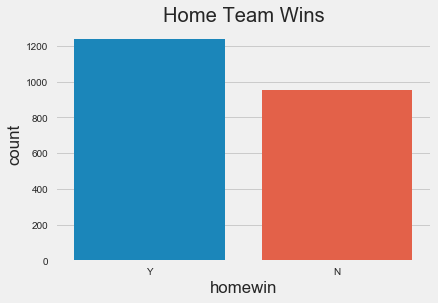

In [31]:
sns.countplot(x='homewin', data=edgelist).set_title("Home Team Wins")

In [32]:
(edgelist[edgelist["homewinbi"]==1].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1)].count()["homewinbi"])
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==3)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==3)].count()["homewinbi"])
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==6)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==6)].count()["homewinbi"])
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==0)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==0)].count()["homewinbi"])

0.54966887417218546

In [33]:
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==3) & (edgelist['awayoffrank']-edgelist['homeoffrank']>-5)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==3)& (edgelist['awayoffrank']-edgelist['homeoffrank']>-5)].count()["homewinbi"])

0.7142857142857143

In [34]:
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==3) & (edgelist['awayoffrank']-edgelist['homeoffrank']>0)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==3)& (edgelist['awayoffrank']-edgelist['homeoffrank']>0)].count()["homewinbi"])

0.765625

In [35]:
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==3) & (edgelist['awayoffrank']-edgelist['homeoffrank']>5)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==3)& (edgelist['awayoffrank']-edgelist['homeoffrank']>5)].count()["homewinbi"])

0.85106382978723405

In [36]:
(edgelist[(edgelist["homewinbi"]==1 )& (edgelist["day"]==3) & (edgelist['awayoffrank']-edgelist['homeoffrank']>10)].sum()["homewinbi"])/(edgelist[(edgelist["homewinbi"]>-1 )& (edgelist["day"]==3)& (edgelist['awayoffrank']-edgelist['homeoffrank']>10)].count()["homewinbi"])

0.875

Text(0.5,1,'Home Win Percentage based on Day of Week')

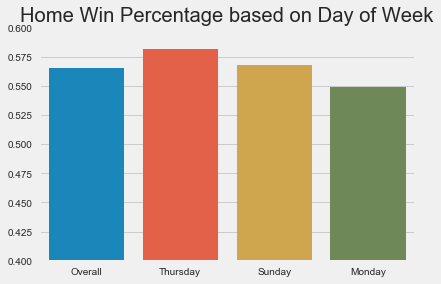

In [37]:
x1=['Overall','Thursday','Sunday', 'Monday']
y1= [0.565,0.582,0.568,0.549]
g=sns.barplot(x=x1, y=y1)
g.set(ylim=(0.4, .6))
g.set_title("Home Win Percentage based on Day of Week")

Text(0.5,1,'Home Win Percentage based on Offensive Rank Difference')

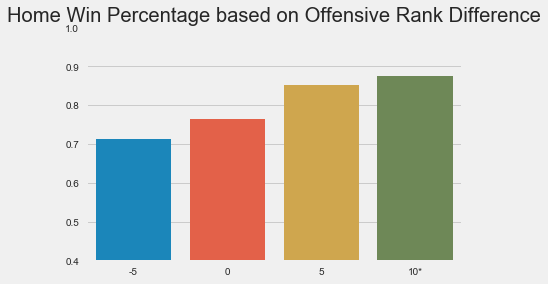

In [38]:
x1=['-5','0','5','10*']
y1= [0.714,0.765,0.851,0.875]
g=sns.barplot(x=x1, y=y1)
g.set(ylim=(0.4, 1))
g.set_title("Home Win Percentage based on Offensive Rank Difference")

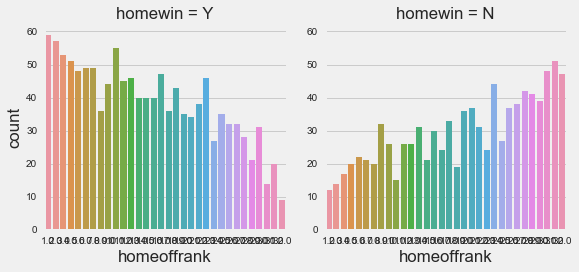

In [39]:
sns.factorplot(x='homeoffrank', col='homewin', kind='count', data=edgelist);
#top offensive rank has a high number of wins

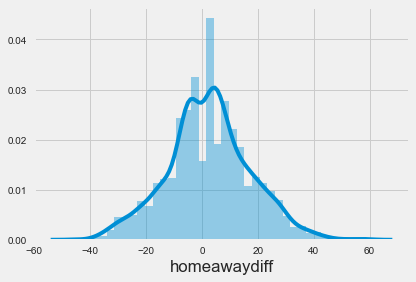

count    2191.000000
mean        2.460977
std        14.848957
min       -45.000000
25%        -7.000000
50%         3.000000
75%        11.000000
max        59.000000
Name: homeawaydiff, dtype: float64

In [40]:
sns.distplot(edgelist['homeawaydiff'])
plt.show()
edgelist['homeawaydiff'].describe()

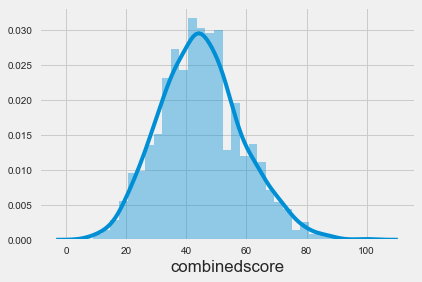

count    2191.000000
mean       44.887266
std        13.839345
min         6.000000
25%        35.000000
50%        44.000000
75%        54.000000
max       101.000000
Name: combinedscore, dtype: float64

In [41]:
sns.distplot(edgelist['combinedscore'])
plt.show()
edgelist['combinedscore'].describe()

Basic "almost" complete graph showing the which teams play which teams. Arrow will point to winner

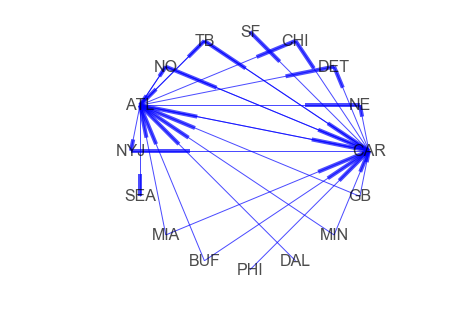

In [42]:
nx.draw_circular(Car,node_size=0, alpha=0.7, edge_color='b', font_size=16, with_labels=True,arrowstyle='-|>', arrowsize=20,  arrows=True)
plt.axis('equal')
plt.show()

Win triangles. If a team beat an opponent and the opponent beat the second opennet that the first team will beat the second opennet.

First, the random games are selected to be tested. They are assigned an "A" instead of "Y"/"N" for the homewin prediction variable. The games selected games have to taken place after a certain week to gather enough seasonal matchup data to accurately predict. 

In [43]:
for (u, v) in C.edges():
    if C[u][v]['nflweek']>10:
        if random.random() > .8:
            C[u][v].update({'homewin':'A'})
            C[u][v].update({'tested edge':1})

Network analysis, looking at if 

In [44]:
def predwintriangles(C):
    hw=0
    hww=0
    hwww=0
    hwwl=0
    for n1 in C.nodes: 
        neighbors1 = set(C.neighbors(n1))
        for n2 in neighbors1: 
            neighbors2 = set(C.neighbors(n2)) 
            common = list(neighbors1 & neighbors2)
            #add in Thursday night home team win
            if C.edges[(n1,n2)]['homewin']== 'A':
                if C.edges[(n1,n2)]['day']== 3:
                    if (C.edges[(n1,n2)]['homeoffrank'] + 10)< C.edges[(n1,n2)]['awayoffrank']:
                        C[n1][n2].update({'homewin':'Y'}) 
            if C.edges[(n1,n2)]['homewin']== 'Y':
                #print(n1,n2)
                #print(C[n1][n2])
                hw=hw+1
                #print(hw)
                for n3 in common:
                    if C.edges[(n2,n3)]['homewin']== 'Y':
                        hww=hww+1
                        if C.edges[(n1,n3)]['homewin']== 'A':
                            if (C.edges[(n1,n2)]['homeoffrank'] + 10)< C.edges[(n1,n3)]['awayoffrank']:
                                C[n1][n3].update({'homewin':'Y'})
                                hwww=hwww+1
    #print(hw)

In [45]:
predwintriangles(C)

In [46]:
df = nx.to_pandas_edgelist(C,'away','home')
#df.head()

In [47]:
#testing line to make sure games were seeded
df[df["tested edge"] ==1 ].sum()["tested edge"]

74

In [48]:
#filter dataframe on games that were predicted
df=df[(df.homewin != 'A') & (df["tested edge"] == 1)]
df["tested correct"]=np.where(df['homewin']==df['predhomewin'],1,0)
(df[df["tested correct"]== 1].sum()["tested correct"])/(df[df["tested edge"]== 1].sum()["tested edge"])

0.6944444444444444

Result data. Ran five random sample runs for each iteration of the model, the output was the number of predicted correctly games divided by the number of predicted games. 

In [ ]:
#Basic Triads
#1st run 0.54
#2nd run 0.62
#3rd run 0.58
#4th run 0.525
#5th run 0.62
#average 

#Add Thursday logic add
#1st run 0.64
#2nd run 0.54
#3rd run 0.53
#4th run 0.62
#5th run 0.62
#average 

#Thursday + thursday offensive rank
#1st run 0.54
#2nd run 0.55
#3rd run 0.62
#4th run 0.51
#5th run 0.58
#average 

#Thursday + thursday offensive rank with 10 rank buffer
#1st run 0.64
#2nd run 0.66
#3rd run 0.65
#4th run 0.62
#5th run 0.64
#average 

#added 10 rank buffer on triad logic
#1st run 0.83
#2nd run 0.69
#3rd run 0.79
#4th run 0.65
#5th run 0.76
#average 0.744


Implement basic machine learning and classifers. To have a baseline to compare the triad logic to.

In [49]:
#encode text variables to numerical
a=LabelEncoder()
column = ['home','away','homewin','date']
for col_name in column:
    edgelist[col_name] = a.fit_transform(edgelist[col_name].astype('str'))

In [50]:
#selecting what variables to use from the original dataframe
new = edgelist[['home', 'away', 'Season','date','combinedscore','month','nflweek','day','homeoffrank','awayoffrank']].copy()
#set dependent(Y) variable
Y = edgelist['homewin']
X = new
#split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
#verify
X_train.head()

,home,away,Season,date,combinedscore,month,nflweek,day,homeoffrank,awayoffrank
1977,2,18,2017,388,40,10,7,3,9.0,28.0
2184,8,33,2017,403,52,11,12,3,14.0,16.0
1310,2,4,2014,227,48,9,3,6,8.0,19.0
1102,33,8,2013,214,47,12,15,6,23.0,5.0
613,27,2,2011,116,48,12,14,6,6.0,12.0


In [51]:
#
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, Y_train)
logpredict = logreg.predict(X_test)

In [52]:
print('Logistic Regression Results')
print('  ')
print('5-fold Cross Validation results')
print('  ')
print(cross_val_score(logreg, X, Y, cv=5))
print('  ')
print('Accuracy')
print('  ')
print(accuracy_score(Y_test, logpredict))



Logistic Regression Results
  
5-fold Cross Validation results
  
[ 0.70615034  0.6803653   0.68949772  0.64383562  0.68949772]
  
Accuracy
  
0.673357664234


**Appendix**

In [ ]:
def wintriangles(C):
    hw=0
    hww=0
    hwww=0
    hwwl=0
    for n1 in C.nodes: 
        neighbors1 = set(C.neighbors(n1))
        for n2 in neighbors1: 
            neighbors2 = set(C.neighbors(n2)) 
            common = list(neighbors1 & neighbors2)
            if C.edges[(n1,n2)]['homewin']== 'Y':
                print(n1,n2)
                #print(C[n1][n2])
                hw=hw+1
                #print(hw)
                for n3 in common:
                    #print(n1,n2,n3)
                    #print(C[n2][n3])
                    if C.edges[(n2,n3)]['homewin']== 'Y':
                        hww=hww+1
                        if C.edges[(n1,n3)]['homewin']== 'Y':
                            hwww=hwww+1
                        else:
                            hwwl=hwwl+1
    print(hwww,hwwl)

In [ ]:
def printout(C):
    for e1 in C.edges:
        print(e1)

In [ ]:
#R scraping code:
devtools::install_github(repo = "maksimhorowitz/nflscrapR")

# This file generates charts summarizing the performances of teams in the
# current NFL season using nflscrapR expected points and win probability.

# Access tidyverse
# install.packages("tidyverse")
library(tidyverse)
library(rvest)

# Pull season result data from nflscrapr github repo
#pbp_18 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_2018.csv")

games_09 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2009.csv")
games_10 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2010.csv")
games_11 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2011.csv")
games_12 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2012.csv")
games_13 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2013.csv")
games_14 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2014.csv")
games_15 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2015.csv")
games_16 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2016.csv")
games_17 <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_games/games_2017.csv")

#combine results into one dataframe
gamestotal = rbind(games_09, games_10, games_11, games_12,games_13,games_14,games_15,games_16,games_17)
gamestotal$winner <- ifelse(gamestotal$homeawaydiff > 0, gamestotal$home, gamestotal$away)
gamestotal$loser <- ifelse(gamestotal$homeawaydiff < 0, gamestotal$home, gamestotal$away)
gamestotal$homeawaydiff <- gamestotal$homescore - gamestotal$awayscore 
gamestotal$homekey <-paste0(gamestotal$home, gamestotal$Season)
gamestotal$awaykey <-paste0(gamestotal$away, gamestotal$Season)
gamestotal$totalpoints<-gamestotal$homescore + gamestotal$awayscore 
gamestotal$homewin<- ifelse(gamestotal$homeawaydiff > 0, 'Y', 'N')

#stats per player per season
passingstats <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_team_stats/team_season_passing_df.csv")
receivingstats <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_team_stats/team_season_receiving_df.csv")
rushingstats <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/season_team_stats/team_season_rushing_df.csv")

#stats per player per game
gamepashingstats <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/game_team_stats/game_passing_df.csv")
gamerushingstats <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/game_team_stats/game_rushing_df.csv")
gamereceivingstats <- read_csv("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/legacy_data/game_team_stats/game_receiving_df.csv")

write.csv(gamestotal,"nflgamestotal.csv")

#pull offensive stats tables from www.pro-football-reference.com

offensivestats2017 <- "https://www.pro-football-reference.com/years/2017/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

newname<-list("OffRk","Tm","G","PF","Yds","Ply","Y/P","TO","FL","1st","PassCmp","PassAtt","PassYds","PassTD",
              "PassInt","PassNY/A","Pass1stD","RushAtt","RushYds","RushTD","RushY/A","Rush1stD",
              "Pen","PenYds","Pen1stPy","Sc%","TO%","EXP")
names(offensivestats2017)<-newname
offensivestats2017 = offensivestats2017[-1,]
offensivestats2017$season = 2017

offensivestats2016 <- "https://www.pro-football-reference.com/years/2016/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2016)<-newname
offensivestats2016 = offensivestats2016[-1,]
offensivestats2016$season = 2016

offensivestats2015 <- "https://www.pro-football-reference.com/years/2015/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2015)<-newname
offensivestats2015 = offensivestats2015[-1,]
offensivestats2015$season = 2015

offensivestats2014 <- "https://www.pro-football-reference.com/years/2014/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2014)<-newname
offensivestats2014 = offensivestats2014[-1,]
offensivestats2014$season = 2014

offensivestats2013 <- "https://www.pro-football-reference.com/years/2013/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2013)<-newname
offensivestats2013 = offensivestats2013[-1,]
offensivestats2013$season = 2013

offensivestats2012 <- "https://www.pro-football-reference.com/years/2012/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2012)<-newname
offensivestats2012 = offensivestats2012[-1,]
offensivestats2012$season = 2012

offensivestats2011 <- "https://www.pro-football-reference.com/years/2011/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2011)<-newname
offensivestats2011 = offensivestats2011[-1,]
offensivestats2011$season = 2011

offensivestats2010 <- "https://www.pro-football-reference.com/years/2010/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2010)<-newname
offensivestats2010 = offensivestats2010[-1,]
offensivestats2010$season = 2010

offensivestats2009 <- "https://www.pro-football-reference.com/years/2009/" %>% read_html() %>% html_nodes(xpath = '//comment()') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#team_stats') %>%    # select desired node
  html_table() 

names(offensivestats2009)<-newname
offensivestats2009 = offensivestats2009[-1,]
offensivestats2009$season = 2009

#combine offensive stats into one dataframe
offensivetotal = rbind(offensivestats2009, offensivestats2010, offensivestats2011, offensivestats2012,
                   offensivestats2013,offensivestats2014,offensivestats2015,offensivestats2016,offensivestats2017)

write_csv(offensivetotal,"nfloffensivetotal.csv")

results20152 <- "https://www.pro-football-reference.com/years/2015/games.htm" %>% read_html() %>% html_nodes(xpath = '//*[@id="games"]') %>%    # select comments
  html_text() %>%    # extract comment text
  paste(collapse = '') %>%    # collapse to single string
  read_html() %>%    # reread as HTML
  html_node('table#games') %>%    # select desired node
  html_table() 

//*[@id="games"]

#create edgelist to import into python networkx
edgelist <- cbind(gamestotal$home,gamestotal$away,gamestotal$Season)
edgelist <-as.data.frame(edgelist)
edgenames<-list("winner","loser","season")
names(edgelist)<-edgenames
write_csv(edgelist,"nfledgelist.csv")

write_csv(gamestotal,"nflgamestotal.csv")



FiveThirtyEight  2017 preditions website: https://projects.fivethirtyeight.com/2017-nfl-predictions/games/

FiveThirtyEight  2017 preditions pivot table: https://docs.google.com/spreadsheets/d/1tyxEQ3ForQlcm2Si4vaPzQSZ9JH8_ZfT606RxE04aac/edit#gid=606939216

Football's Outsiders Premium picks:
2008 regular season: 147-73-1, .665
2009 regular season: 163-93, .637
2010 regular season: 165-91, .645
2011 regular season: 164-92, .641
2012 regular season: 171-84-1, .670
2013 regular season: 171-84-1, .670
2014 regular season: 162-93-1, .635
2015 regular season: 153-103, .598